In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import settings as st
import seaborn as sns
plt = sns.mpl.pyplot

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


In [3]:
def calculate_full_exposure(row):
    _exposure = 0
    for ii, _det in enumerate(row.detectors):
        if _det=="TRIDENT":
            _exposure += row.timefactors[ii] * st.TRIDENT_FACTOR
        elif _det=="HUNT":
            _exposure += row.timefactors[ii] * st.HUNT_FACTOR
        elif _det=="NEON":
            _exposure += row.timefactors[ii] * st.NEON_FACTOR
        else:
            _exposure += row.timefactors[ii] # icecube-gen2 factor is already accounted for
    return _exposure * 10


In [4]:
# config
exposure_config = pd.read_pickle(join(st.LOCALPATH, f"timeline_configs.pickle"))
config_selection = pd.DataFrame(
    [
        {"Year": 2020, "era": "IceCube"},
        {"Year": 2025, "era": "IceCube"},
        {"Year": 2030, "era": "Plenum-1"},
        {"Year": 2035, "era": "Plenum-1"},
        {"Year": 2040, "era": "Plenum-2"},
        {"Year": 2045, "era": "Plenum-3"},
        {"Year": 2050, "era": "Plenum-3"},
    ]
)
config_selection["exposure"] = 0
for _, cs in config_selection.iterrows():
    selection = exposure_config.loc[
        (exposure_config.Year == cs["Year"]) & (exposure_config.era == cs["era"])
    ]
    config_selection.loc[_, "exposure"] = calculate_full_exposure(selection.iloc[0])

In [5]:
ngc_flux_psd = pd.read_csv(
    "../../resources/ngc_point-source_discovery_time-evolution.csv"
)
ngc_flux_psd.scaled_flux = 1e13 * ngc_flux_psd.dp_flux
ngc_flux_psd.rename(columns={"dec_label": "Declination"}, inplace=True)
ngc_flux_psd["Era"] = ""
ngc_flux_psd.loc[ngc_flux_psd.era == "IceCube", "Era"] = r"IceCube-only"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-1", "Era"] = r"PLE$\nu$M-1"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-2", "Era"] = r"PLE$\nu$M-2"
ngc_flux_psd.loc[ngc_flux_psd.era == "Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
ngc_flux_psd_min = (
    ngc_flux_psd.loc[ngc_flux_psd.sigma == 5]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
ngc_flux_psd.loc[
    (ngc_flux_psd.era == "Plenum-2")
    & (ngc_flux_psd.dec == -30)
    & (ngc_flux_psd.sigma == 5),
    ["dp_flux", "scaled_flux"],
] = 0

In [6]:
txs_flux_psd = pd.read_csv(
    "../../resources/txs_point-source_discovery_time-evolution.csv"
)
# 1E4 for 100 TeV to 1 TeV pivot energy
txs_flux_psd.scaled_flux = 1E15 * 1E4 * txs_flux_psd.dp_flux
txs_flux_psd.rename(columns={"dec_label": "Declination"}, inplace=True)
txs_flux_psd["Era"] = ""
txs_flux_psd.loc[txs_flux_psd.era=="IceCube", "Era"] = r"IceCube-only"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-1", "Era"] = r"PLE$\nu$M-1"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-2", "Era"] = r"PLE$\nu$M-2"
txs_flux_psd.loc[txs_flux_psd.era=="Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
txs_flux_psd_min = (
    txs_flux_psd.loc[txs_flux_psd.sigma == 5]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
txs_flux_psd.loc[
    (txs_flux_psd.era == "Plenum-2")
    & (txs_flux_psd.dec == -30)
    & (txs_flux_psd.sigma == 5),
    ["dp_flux", "scaled_flux"],
] = 0

# plot DP vs. exposure

In [7]:
exposure_config["exposure"] = exposure_config.apply(lambda x: calculate_full_exposure(x), axis=1)

[]

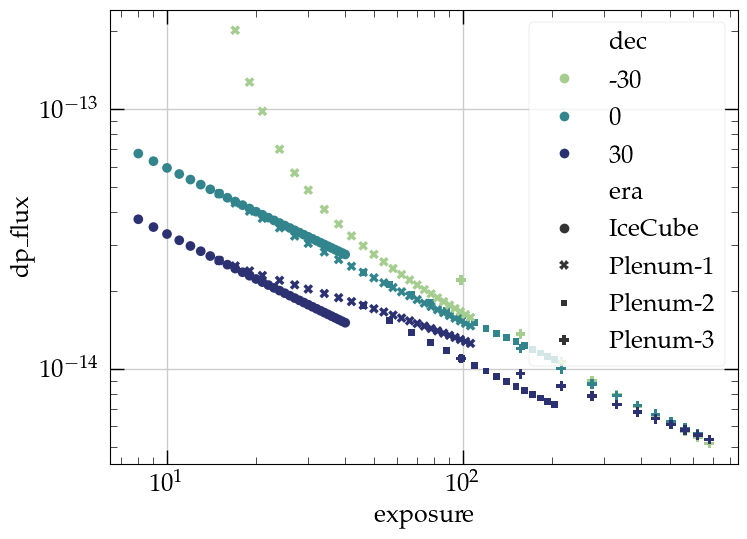

In [8]:
# all exposures - ngc
ngc_flux_psd["exposure"] = 0
for _i, row in exposure_config.iterrows():
    ngc_flux_psd.loc[
        (ngc_flux_psd.Year == row.Year) & (ngc_flux_psd.era == row.era),
        "exposure",
    ] = row.exposure

ax = sns.scatterplot(
    data=ngc_flux_psd.loc[(ngc_flux_psd.sigma == 5)],
    x="exposure",
    y="dp_flux",
    hue="dec",
    style="era",
    palette="crest",
    marker="o",
    lw=0,
)
ax.loglog()

[]

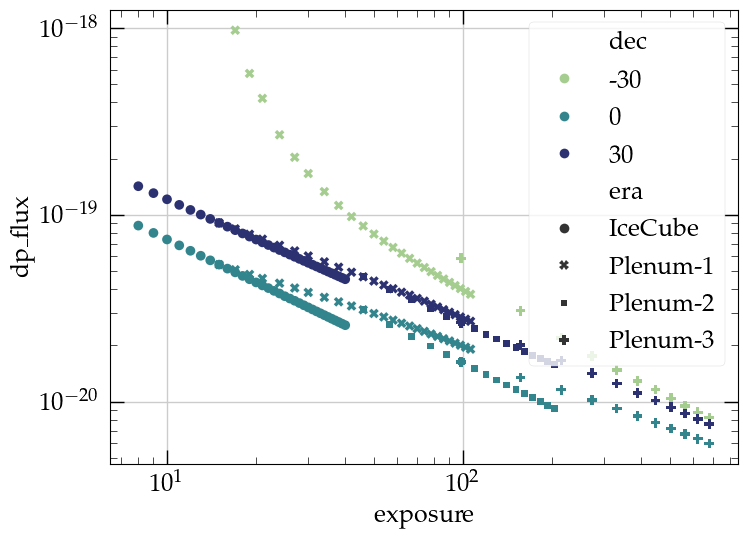

In [9]:
# all exposures - txs
txs_flux_psd["exposure"] = 0
for _i, row in exposure_config.iterrows():
    txs_flux_psd.loc[
        (txs_flux_psd.Year == row.Year) & (txs_flux_psd.era == row.era),
        "exposure",
    ] = row.exposure

ax = sns.scatterplot(
    data=txs_flux_psd.loc[(txs_flux_psd.sigma == 5)],
    x="exposure",
    y="dp_flux",
    hue="dec",
    style="era",
    palette="crest",
    marker="o",
    lw=0,
)
ax.loglog()

# determine scaling

In [27]:
txs_scalings = (
    txs_flux_psd.groupby(["era", "dec"])
    .apply(lambda x: np.polyfit(np.log10(x.exposure), np.log10(x.dp_flux), deg=1)[0])
    .reset_index(name="scaling_index")
)

ngc_scalings = (
    ngc_flux_psd.groupby(["era", "dec"])
    .apply(lambda x: np.polyfit(np.log10(x.exposure), np.log10(x.dp_flux), deg=1)[0])
    .reset_index(name="scaling_index")
)

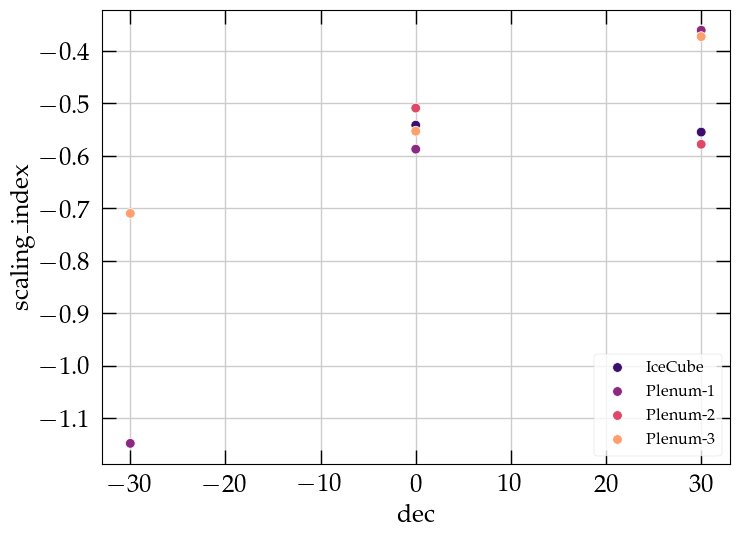

In [32]:
ax = sns.scatterplot(
    data=ngc_scalings, x="dec", y="scaling_index", hue="era", palette="magma"
)
ax.legend(loc=4, fontsize="small")


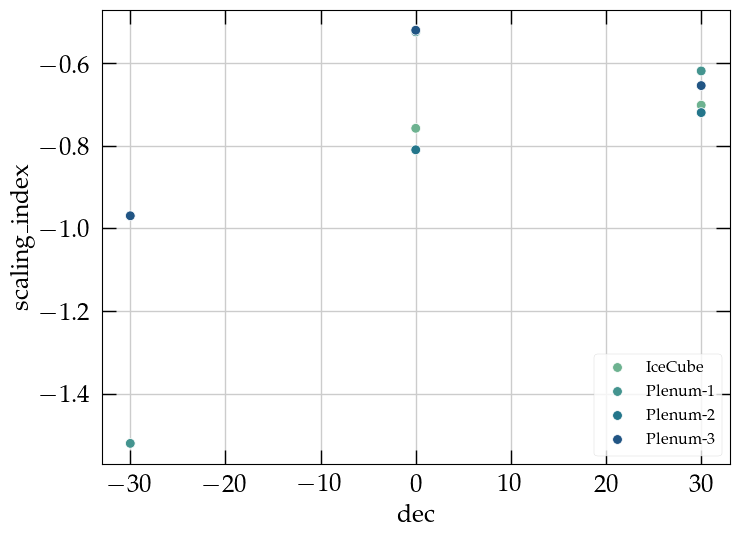

In [34]:
ax = sns.scatterplot(
    data=txs_scalings, x="dec", y="scaling_index", hue="era", palette="crest"
)
ax.legend(loc=4, fontsize="small")

# maximum exposure only


[]

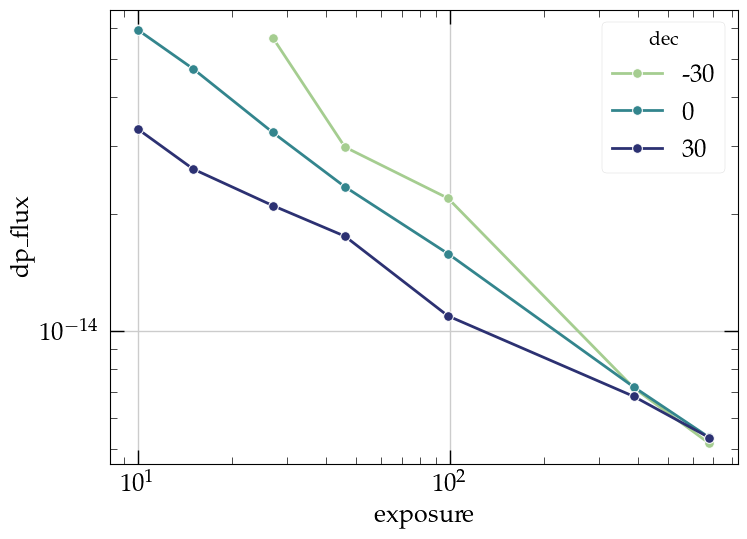

In [10]:
_tmp = []
for _i, row in config_selection.iterrows():
    _selection = pd.DataFrame(ngc_flux_psd_min.loc[
            (ngc_flux_psd_min.Year == row.Year) & (ngc_flux_psd_min.era == row.era), "dp_flux"
        ]).reset_index().drop(columns="level_2")
    _selection["exposure"] = row.exposure
    _tmp.append(_selection)
max_exposure_dp = pd.concat(_tmp, ignore_index=True)
max_exposure_dp.head()
ax = sns.lineplot(
    data=max_exposure_dp,
    x="exposure",
    y="dp_flux",
    hue="dec",
    palette="crest",
    marker="o",
)
ax.loglog()

# format exposure to table

In [11]:
exposure_config["exposure"] = 0
for _idx, row in exposure_config.iterrows():
    exposure_config.loc[_idx, "exposure"] = calculate_full_exposure(row)
tab_for_latex = exposure_config[["era", "Year", "exposure"]].sort_values("era")
tab_for_latex = tab_for_latex.pivot(columns="era", index="Year").fillna("-")

In [12]:
print(tab_for_latex.to_latex(float_format="%.1f")) #  appendix "Exposure"

\begin{tabular}{lrlll}
\toprule
 & \multicolumn{4}{r}{exposure} \\
era & IceCube & Plenum-1 & Plenum-2 & Plenum-3 \\
Year &  &  &  &  \\
\midrule
2018 & 8.0 & - & - & - \\
2019 & 9.0 & - & - & - \\
2020 & 10.0 & - & - & - \\
2021 & 11.0 & - & - & - \\
2022 & 12.0 & - & - & - \\
2023 & 13.0 & - & - & - \\
2024 & 14.0 & - & - & - \\
2025 & 15.0 & 15.0 & - & - \\
2026 & 16.0 & 17.0 & - & - \\
2027 & 17.0 & 19.0 & - & - \\
2028 & 18.0 & 21.0 & - & - \\
2029 & 19.0 & 24.0 & - & - \\
2030 & 20.0 & 27.0 & - & - \\
2031 & 21.0 & 30.0 & - & - \\
2032 & 22.0 & 34.0 & - & - \\
2033 & 23.0 & 38.0 & - & - \\
2034 & 24.0 & 42.0 & - & - \\
2035 & 25.0 & 46.0 & 46.0 & - \\
2036 & 26.0 & 50.0 & 56.5 & - \\
2037 & 27.0 & 54.0 & 67.0 & - \\
2038 & 28.0 & 58.0 & 77.5 & - \\
2039 & 29.0 & 62.0 & 88.0 & - \\
2040 & 30.0 & 66.0 & 98.5 & 98.5 \\
2041 & 31.0 & 70.0 & 109.0 & 156.5 \\
2042 & 32.0 & 74.0 & 119.5 & 214.5 \\
2043 & 33.0 & 78.0 & 130.0 & 272.5 \\
2044 & 34.0 & 82.0 & 140.5 & 330.5 \\
2045 & 35.0 & 